# 1. Replace GRU with LSTM in the experiment.

In [22]:
import sys
import torch.nn as nn
import torch
import warnings
from sklearn.model_selection import ParameterGrid
sys.path.append('/home/jovyan/work/d2l_solutions/notebooks/exercises/d2l_utils/')
import d2l
from torchsummary import summary
warnings.filterwarnings("ignore")

# class LSTM(d2l.RNN):
#     def __init__(self, num_inputs, num_hiddens, num_layers,
#                  dropout=0):
#         d2l.Module.__init__(self)
#         self.save_hyperparameters()
#         self.rnn = nn.LSTM(num_inputs, num_hiddens)

#     def forward(self, inputs, H_C=None):
#         return self.rnn(inputs, H_C)

class AttentionDecoder(d2l.Decoder):  #@save
    """The base attention-based decoder interface."""
    def __init__(self):
        super().__init__()

    @property
    def attention_weights(self):
        raise NotImplementedError
        
class Seq2SeqAttentionLSTMDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.attention = d2l.AdditiveAttention(num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(
            embed_size + num_hiddens, num_hiddens, num_layers=num_layers,
            dropout=dropout)
        # self.rnn = nn.GRU(
        #     embed_size + num_hiddens, num_hiddens, num_layers,
        #     dropout=dropout)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(d2l.init_seq2seq)

    def init_state(self, enc_outputs, enc_valid_lens):
        # Shape of outputs: (num_steps, batch_size, num_hiddens).
        # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
        outputs, hidden_state = enc_outputs
        # return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)
        # outputs, hidden_state, c_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        # Shape of enc_outputs: (batch_size, num_steps, num_hiddens).
        # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
        # enc_outputs, hidden_state, enc_valid_lens = state
        enc_outputs, hidden_state, enc_valid_lens = state
        enc_valid_lens = None
        # Shape of the output X: (num_steps, batch_size, embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            # Shape of query: (batch_size, 1, num_hiddens)
            # query = torch.unsqueeze(hidden_state[-1], dim=1)
            query = torch.unsqueeze(hidden_state[0][-1], dim=1)
            # Shape of context: (batch_size, 1, num_hiddens)
            context = self.attention(
                query, enc_outputs, enc_outputs, enc_valid_lens)
            # Concatenate on the feature dimension
            
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # Reshape x as (1, batch_size, embed_size + num_hiddens)
            # print(x.permute(1, 0, 2).shape, hidden_state.shape)
            # out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # After fully connected layer transformation, shape of outputs:
        # (num_steps, batch_size, vocab_size)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,
                                          enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights

In [23]:
data = d2l.MTFraEng(batch_size=128)
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = d2l.Seq2SeqEncoder(
    len(data.src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionLSTMDecoder(
    len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = d2l.Seq2Seq(encoder, decoder, tgt_pad=data.tgt_vocab['<pad>'],
                    lr=0.005)
trainer = d2l.Trainer(max_epochs=30, gradient_clip_val=1)
trainer.fit(model, data)

RuntimeError: The size of tensor a (256) must match the size of tensor b (9) at non-singleton dimension 2

In [21]:
c(x,d[1])

(tensor([[[ 0.1941,  0.0038]],
 
         [[ 0.2071, -0.0495]]], grad_fn=<MkldnnRnnLayerBackward0>),
 (tensor([[[ 0.1552, -0.6921]],
  
          [[ 0.2071, -0.0495]]], grad_fn=<StackBackward0>),
  tensor([[[ 1.7040, -0.8714]],
  
          [[ 0.4635, -0.1087]]], grad_fn=<StackBackward0>)))

In [13]:
c = nn.LSTM(3, 2, num_layers=num_layers,dropout=dropout)
d = c(x)
d[1]

(tensor([[[ 0.1607, -0.6806]],
 
         [[ 0.1192,  0.0336]]], grad_fn=<StackBackward0>),
 tensor([[[ 1.4335, -0.8491]],
 
         [[ 0.3154,  0.0753]]], grad_fn=<StackBackward0>))

In [11]:
a = nn.GRU(3, 2, num_layers,
                          dropout=dropout)
x = torch.range(1,6).reshape(2,1,-1)
b = a(x)
b[0].shape,b[1].shape

(torch.Size([2, 1, 2]), torch.Size([2, 1, 2]))

# 2. Modify the experiment to replace the additive attention scoring function with the scaled dot-product. How does it influence the training efficiency?

In [3]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
_, dec_attention_weights = model.predict_step(
    data.build([engs[-1]], [fras[-1]]), 'cpu', data.num_steps, True)
attention_weights = torch.cat(
    [step[0][0][0] for step in dec_attention_weights], 0)
attention_weights = attention_weights.reshape((1, 1, -1, data.num_steps))

# Plus one to include the end-of-sequence token
# d2l.show_heatmaps(
#     attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
#     xlabel='Key positions', ylabel='Query positions')

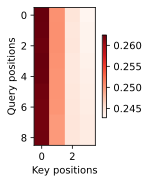

In [4]:
d2l.show_heatmaps(
    attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
    xlabel='Key positions', ylabel='Query positions')